This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

In [1]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [2]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

In [3]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
#Geometry and residual
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)



def pde(x, y):
    # Most backends
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    # Backend pytorch
    return (
        dy_t
        - dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
        )

In [5]:
#Conditions (Boudary & Initial)
def IC_func(x):
    return np.sin(np.pi * x[:, 0:1])

def BC_func(x):
    return 0


ic = dde.icbc.IC(geomtime, IC_func, lambda _, on_initial: on_initial)
bc = dde.icbc.DirichletBC(geomtime, BC_func, lambda _, on_boundary: on_boundary)


In [6]:
#Data and model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    num_test=10000,
)


layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

Compiling model...
'compile' took 0.000663 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [7.08e-05, 7.00e-06, 5.07e-06]    [1.44e-04, 7.00e-06, 5.07e-06]    []  
11000     [2.22e-05, 4.86e-06, 3.84e-06]    [9.89e-05, 4.86e-06, 3.84e-06]    []  
12000     [1.95e-05, 4.97e-06, 3.45e-06]    [9.15e-05, 4.97e-06, 3.45e-06]    []  
13000     [9.12e-04, 4.54e-05, 1.26e-05]    [7.08e-04, 4.54e-05, 1.26e-05]    []  
14000     [1.01e-04, 9.87e-06, 3.38e-06]    [1.49e-04, 9.87e-06, 3.38e-06]    []  
15000     [1.45e-05, 4.89e-06, 3.19e-06]    [7.79e-05, 4.89e-06, 3.19e-06]    []  
16000     [6.00e-05, 7.38e-06, 3.34e-06]    [1.10e-04, 7.38e-06, 3.34e-06]    []  
17000     [1.20e-05, 4.89e-06, 2.82e-06]    [7.46e-05, 4.89e-06, 2.82e-06]    []  
18000     [8.06e-05, 7.15e-06, 6.26e-06]    [1.20e-04, 7.15e-06, 6.26e-06]    []  
19000     [1.05e-05, 4.72e-06, 2.86e-06]    [7.18e-05, 4.72e-06, 2.86e-06]    []  
20000     [2.46

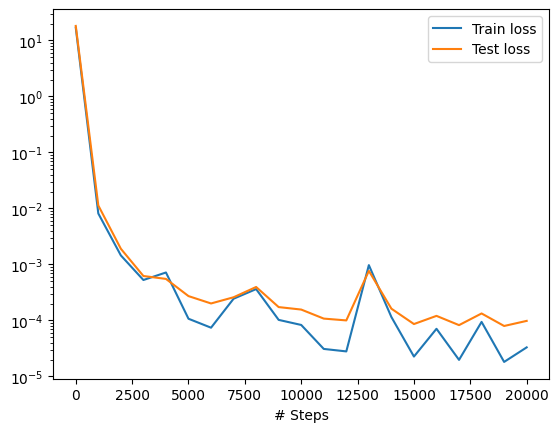

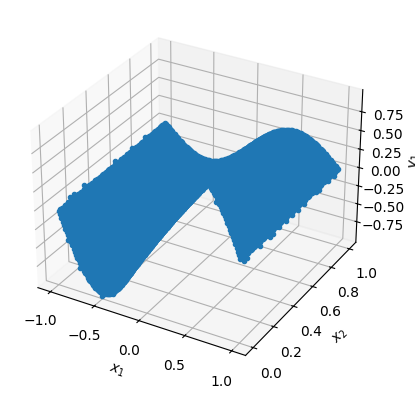

In [8]:
#Computations and graph
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)



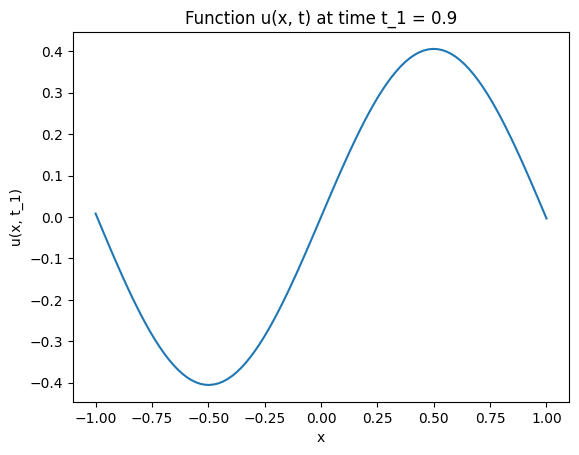

In [14]:
# Define the time t_1 at which you want to display the function
t_1 = 0.9

# Define the spatial domain where you want to evaluate the function
x = np.linspace(-1, 1, 100)

# Evaluate the function u(x, t) at the specified time t_1 and spatial domain x
u_x_t1 = model.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)]))) #Makes a vertical 2d vector

# Plot the function u(x, t) at time t_1
plt.plot(x, u_x_t1)
plt.xlabel('x')
plt.ylabel('u(x, t_1)')
plt.title('Function u(x, t) at time t_1 = {}s.'.format(t_1))
plt.show()